In [1]:
api_token = {"username":"vito0520","key":"16c8b984652ab89b49c930761b822408"}
import json
import zipfile
import os
 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
 
!ls /kaggle

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)
chest-xray-pneumonia.zip


In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Model
from keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
import os.path
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D,BatchNormalization
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import SeparableConv2D

In [3]:
import os
import zipfile
local_zip = '/kaggle/chest-xray-pneumonia.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
for dirname, _, filenames in os.walk('/tmp/chest_xray'):
    for filename in filenames:
        
        os.path.join(dirname, filename)

In [5]:
num_classes = 2
img_rows, img_cols = 300, 300
batch_size = 16
train_data_dir = '/tmp/chest_xray/train'
validation_data_dir = '/tmp/chest_xray/test'

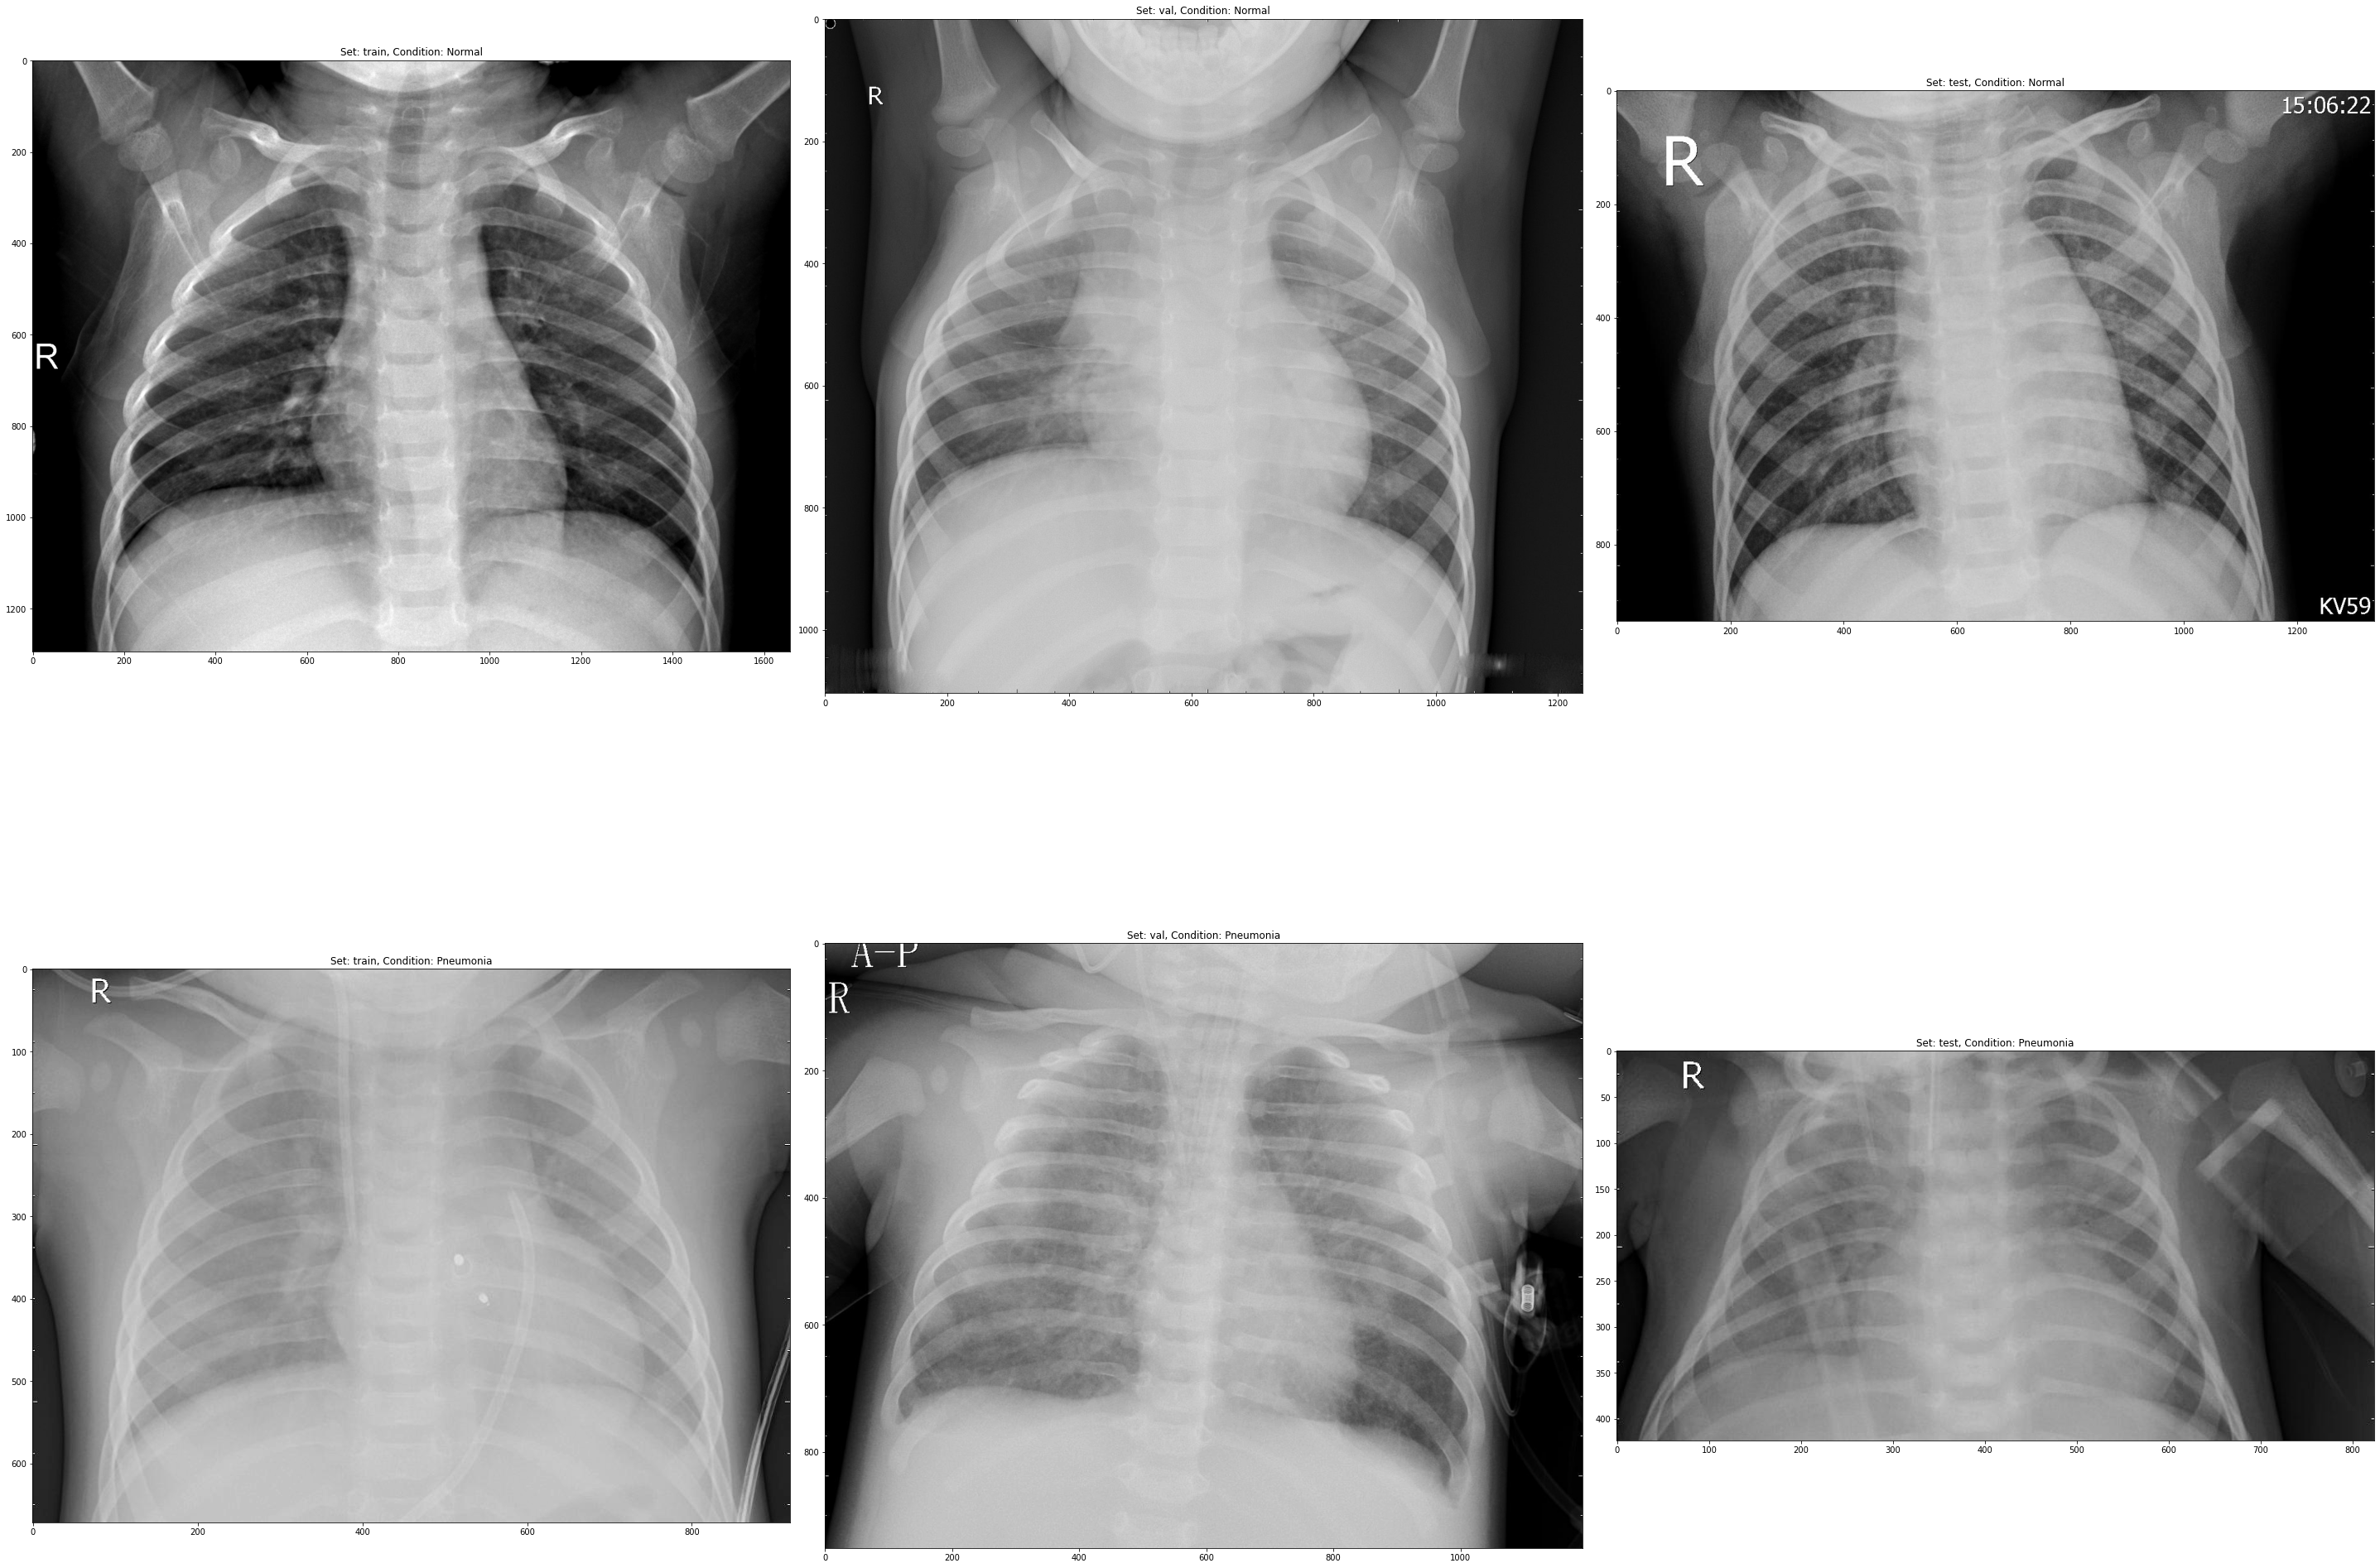

In [6]:
inputs = ('/tmp/chest_xray/')

fig, ax = plt.subplots(2, 3, figsize=(40, 30))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = inputs+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')

In [9]:
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

Found 5216 images belonging to 2 classes.


In [10]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 624 images belonging to 2 classes.


In [12]:

model = Sequential()

model.add(Conv2D(16, (3, 3),input_shape= (150, 150, 3)))
model.add(Conv2D(16, (3, 3),activation='relu',padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(SeparableConv2D(32, (3, 3),activation='relu',padding='same'))
model.add(SeparableConv2D(32, (3, 3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(SeparableConv2D(64, (3, 3),activation='relu',padding='same'))
model.add(SeparableConv2D(64, (3, 3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(SeparableConv2D(128, (3, 3),activation='relu',padding='same'))
model.add(SeparableConv2D(128, (3, 3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(SeparableConv2D(360, (3, 3),activation='relu',padding='same'))
model.add(SeparableConv2D(360, (3, 3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())



model.add(Dense(units=512,activation='relu')) 
model.add(Dropout(0.5))

model.add(Dense(units=256,activation='relu')) 
model.add(Dropout(0.5))

model.add(Dense(units=128,activation='relu'))  
model.add(Dropout(0.3))

model.add(Dense(units=32,activation='relu')) 
model.add(Dropout(0.2))

model.add(Dense(2,activation="softmax"))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 74, 74, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 74, 74, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 74, 74, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0

In [13]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = "adam",
              metrics = ['accuracy'])

In [14]:
history = model.fit_generator(
    train_generator,
    use_multiprocessing=True,
    workers=16,
    epochs = 10,
    validation_data = validation_generator
    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
326/326 [==============================] - 350s 1s/step - loss: 0.3941 - accuracy: 0.8137 - val_loss: 0.6662 - val_accuracy: 0.6250
Epoch 2/10
326/326 [==============================] - 351s 1s/step - loss: 0.3250 - accuracy: 0.8566 - val_loss: 2.9704 - val_accuracy: 0.6250
Epoch 3/10
326/326 [==============================] - 353s 1s/step - loss: 0.2764 - accuracy: 0.8911 - val_loss: 1.8547 - val_accuracy: 0.6250
Epoch 4/10
326/326 [==============================] - 355s 1s/step - loss: 0.2652 - accuracy: 0.8901 - val_loss: 2.1190 - val_accuracy: 0.6250
Epoch 5/10
326/326 [==============================] - 353s 1s/step - loss: 0.2912 - accuracy: 0.8808 - val_loss: 0.6160 - val_accuracy: 0.7548
Epoch 6/10
326/326 [==============================] - 355s 1s/step - loss: 0.2476 - accuracy: 0.8997 - val_loss: 0.5782 - val_accuracy: 0.7099
Epoch 7/10
326/326 [==============================] - 355s 1s/step

In [15]:
model.evaluate(validation_generator,verbose=0)

[0.4569298326969147, 0.8525640964508057]

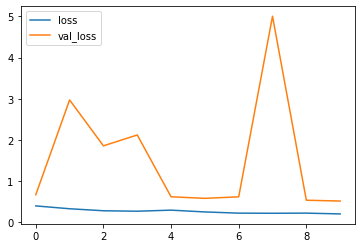

In [16]:
metrics = pd.DataFrame(history.history)
metrics[["loss","val_loss"]].plot()

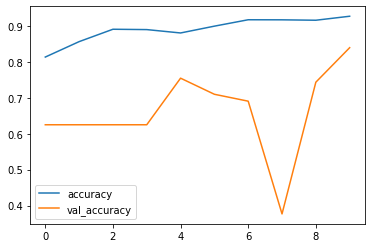

In [17]:
metrics[["accuracy","val_accuracy"]].plot()